# Data Loading

In [392]:
from __future__ import print_function, division
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
import os
import numpy as np

# defining customized Dataset class for Udacity

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class UdacityDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, select_camera=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            select_camera (string): 'left_ / right_ / center_camera'
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        camera_csv = pd.read_csv(csv_file)
        assert select_camera in ['left_camera', 'right_camera', 'center_camera'], "Invalid camera: {}".format(select_camera)
        if select_camera:
            camera_csv = camera_csv[camera_csv['frame_id']==select_camera]
        self.camera_csv = camera_csv
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.camera_csv)
    
    def read_data(self, idx):
        path = os.path.join(self.root_dir, self.camera_csv['filename'].iloc[idx])
        image = io.imread(path)
        timestamp = self.camera_csv['timestamp'].iloc[idx]
        frame_id = self.camera_csv['frame_id'].iloc[idx]
        angle = self.camera_csv['angle'].iloc[idx]
        
        if self.transform:
            image = self.transform(image)
        angle = torch.tensor(angle)
            
        return image, timestamp, frame_id, angle
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if isinstance(idx, int):
            image, timestamp, frame_id, angle = self.read_data(idx)
        else:
            image = []
            timestamp = []
            frame_id = []
            angle = []
            
            for i in idx:
                data = self.read_data(i)
                image.append(data[0])
                timestamp.append(data[1])
                frame_id.append(data[2])
                angle.append(data[3])
            
            image = torch.stack(image)
            angle = torch.stack(angle)
            
        sample = {'image': image,
                  'timestamp': timestamp,
                  'frame_id': frame_id,
                  'angle': angle}
            
        return sample

In [394]:
# test the UdacityDataset class
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler

udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                 root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera='center_camera')

# using DataLoader and batch_size
# this allows multithreading so it has a higher efficiency

sampler = SequentialSampler(udacity_dataset)
dataloader = DataLoader(udacity_dataset, sampler=BatchSampler(sampler, batch_size=4, drop_last=False), collate_fn=(lambda x: x[0]), num_workers=4)

for i_batch, sample_batched in enumerate(dataloader):
    print(sample_batched['image'].shape)
    break

torch.Size([4, 3, 480, 640])


In [395]:
# generate Batch with consecutive frames taken from input data

from torch.utils.data import Sampler
import random

class ConsecutiveBatchSampler(Sampler):
    
    def __init__(self, data_source, batch_size, padding, last_batch_op=None, shuffle=True):
        r""" Sampler to generate consecutive Batches
        
        Args:
            data_source: Source of data
            batch_size: Number of frames in each batch
            padding: Number of frames to insert before each batch
            last_batch_op: Operation to the last batch. Use 'drop', 'fill' or None
            shuffle: Wether to shuffle the data
        """
        self.data_source = data_source
        
        assert batch_size >= 1, "Invalid batch size: {}".format(batch_size)
        self.batch_size = batch_size
        
        assert padding >= 0, "Invalid padding size: {}".format(padding)
        self.padding = padding
        
        assert last_batch_op in ['drop', 'fill', None], "Invalid option last_batch={}".format(last_batch_op)
        self.last_batch=last_batch_op
        
        self.shuffle = shuffle
    
    def __iter__(self):
        length = len(self.data_source)
        start_indices = list(range(0, length, self.batch_size))
        if self.shuffle:
            random.shuffle(start_indices)
        
        for ind in start_indices:
            batch = []
            
            if ind - self.padding < 0:
                batch.extend([0]*(self.padding - ind) + list(range(0, ind)))
            else:
                batch.extend(list(range(ind - self.padding, ind)))
            
            if ind + self.batch_size > length:
                if self.last_batch == 'drop':
                    continue
                elif self.last_batch == 'fill':
                    batch.extend(list(range(ind, length)) + list(range(0, self.batch_size-(length-ind))))
                else:
                    batch.extend(list(range(ind, length)))
            else:
                batch.extend(list(range(ind, ind+self.batch_size)))
            
            yield batch
    
    def __len__(self):
        length = len(self.data_source)
        
        if length % batch_size == 0 or self.last_batch == 'fill':
            return length // batch_size
        
        if self.last_batch == 'drop':
            return length // batch_size
        
        return length // batch_size + 1
            

In [414]:
def show_sample(sample):
    r""" Helper function for (batch) sample visualization
    
    Args:
        sample: Dictionary
    """
    assert len(sample['image'].shape) == 3 or len(sample['image'].shape) == 4, "Unsupported image shape: {}".format(sample['image'].shape)
    if len(sample['image'].shape) == 3:
        plt.imshow(sample['image'])
    else:
        n_batch = sample['image'].shape[0]
        fig, ax = plt.subplots(1, n_batch, figsize=(25, 15))
        for idx, image in enumerate(sample['image']):
            ax[idx].imshow(image.permute(1,2,0))
            ax[idx].axis('off')
            ax[idx].set_title(sample['timestamp'][idx])
            ax[idx].text(10, 30, sample['frame_id'][idx], color='red')
    


CBS sampled sequence:
[[8, 9, 10, 11], [4, 5, 6, 7], [16, 17, 18, 19], [12, 13, 14, 15], [0, 1, 2, 3]]
BS sampled sequence:
[[8, 17, 14, 5], [18, 2, 11, 13], [6, 1, 19, 0], [4, 10, 16, 15], [12, 9, 7, 3]]
Sample image:
<class 'torch.Tensor'>
torch.Size([5, 3, 480, 640])
Sample angle:
<class 'torch.Tensor'>
torch.Size([5])


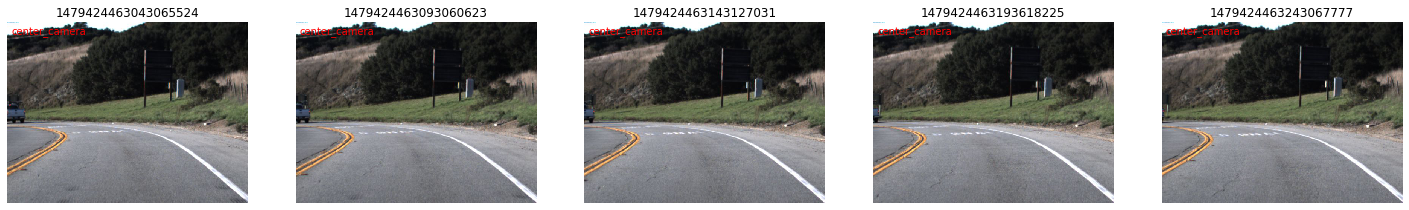

In [416]:
# test the ConsecutiveBatchSampler

dummy_dataset = list(range(0, 20))
cbs = ConsecutiveBatchSampler(data_source=dummy_dataset, batch_size=4, shuffle=True, last_batch_op=None, padding = 0)
print("CBS sampled sequence:")
print(list([a for a in cbs]))
print("BS sampled sequence:")
bs = BatchSampler(RandomSampler(dummy_dataset), batch_size=4, drop_last=False)
print(list([a for a in bs]))
    
#test the sampler on DataLoader

cbs = ConsecutiveBatchSampler(data_source=udacity_dataset, batch_size=4, shuffle=True, last_batch_op=None, padding=1)
dataloader = DataLoader(udacity_dataset, sampler=cbs, num_workers=4, collate_fn=(lambda x: x[0]))
for i_batch, sample_batched in enumerate(dataloader):
    print("Sample image:")
    print(type(sample_batched['image']))
    print(sample_batched['image'].shape)
    print("Sample angle:")
    print(type(sample_batched['angle']))
    print(sample_batched['angle'].shape)
    
    show_sample(sample_batched)
    
    break

In [ ]:
# Model 1
import torch.nn as nn

class Conv3DModel(nn.Module, W_in=640, H_in=480):
    def __init__(self):
        super(Conv3DModel, self).__init__()
        
        
    
    def forward(self, x):
        pass
    
